Find background spectrum from xyY specification
===============================================

In [1]:
import sys
sys.path.insert(0, '../')
import random

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from silentsub.device import StimulationDevice
from silentsub.plotting import stim_plot


sns.set_context('notebook')
sns.set_style('whitegrid')

In [6]:
spds = pd.read_csv('../data/S2_corrected_oo_spectra.csv', index_col=['led','intensity'])
spds.index.rename(['Primary', 'Setting'], inplace=True)
spds.columns = pd.Int64Index(spds.columns.astype(int))

# list of colors for the primaries
colors = ['blueviolet', 'royalblue', 'darkblue', 'blue', 'cyan', 
          'green', 'lime', 'orange', 'red', 'darkred']

# instantiate the class
device = StimulationDevice(
    resolutions=[4095]*10,
    colors=colors,
    spds=spds,
    spd_binwidth=1)
device.spds

380       381       382       383       384       385  \
Primary Setting                                                               
0       0        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        65       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        130      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        195      0.000026  0.000017  0.000041  0.000015  0.000036  0.000039   
        260      0.000141  0.000147  0.000168  0.000170  0.000155  0.000144   
...                   ...       ...       ...       ...       ...       ...   
9       3835     0.003609  0.004056  0.003476  0.003724  0.002943  0.003147   
        3900     0.003415  0.003666  0.003451  0.003724  0.002873  0.003021   
        3965     0.003560  0.003867  0.003539  0.003874  0.003191  0.003165   
        4030     0.003738  0.003652  0.003557  0.003737  0.002973  0.003205   
        4095     0.003459  0.004063  0.003610  0.004071  0.003099  0.003373   

                      386       387       388       389  ...       771  \
Primary Setting                                          ...             
0       0        0.000000  0.000000  0.000000  0.000000  ...  0.000000   
        65       0.000000  0.000000  0.000000  0.000000  ...  0.000000   
        130      0.000000  0.000000  0.000000  0.000000  ...  0.000000   
        195      0.000022  0.000032  0.000026  0.000021  ...  0.000022   
        260      0.000154  0.000121  0.000167  0.000169  ...  0.000088   
...                   ...       ...       ...       ...  ...       ...   
9       3835     0.003482  0.002543  0.003630  0.004153  ...  0.002318   
        3900     0.003112  0.002289  0.003514  0.004000  ...  0.002279   
        3965     0.003544  0.002428  0.003695  0.004005  ...  0.002134   
        4030     0.003420  0.002227  0.003520  0.003932  ...  0.002444   
        4095     0.003231  0.002468  0.003654  0.004141  ...  0.002274   

                          772       773       774       775       776  \
Primary Setting                                                         
0       0        0.000000e+00  0.000000  0.000000  0.000000  0.000000   
        65       0.000000e+00  0.000000  0.000000  0.000000  0.000000   
        130      0.000000e+00  0.000000  0.000000  0.000000  0.000000   
        195      5.119073e-07  0.000008  0.000009  0.000000  0.000015   
        260      7.298278e-05  0.000088  0.000081  0.000071  0.000086   
...                       ...       ...       ...       ...       ...   
9       3835     2.590713e-03  0.002629  0.002536  0.002962  0.002583   
        3900     2.669694e-03  0.002370  0.002300  0.002815  0.002574   
        3965     2.682856e-03  0.002604  0.002552  0.002775  0.002638   
        4030     2.647269e-03  0.002541  0.002408  0.002702  0.002547   
        4095     2.544598e-03  0.002587  0.002493  0.002923  0.002699   

                      777       778       779       780  
Primary Setting                                          
0       0        0.000000  0.000011  0.000000  0.000000  
        65       0.000000  0.000000  0.000000  0.000000  
        130      0.000000  0.000000  0.000000  0.000000  
        195      0.000012  0.000000  0.000018  0.000000  
        260      0.000086  0.000010  0.000100  0.000078  
...                   ...       ...       ...       ...  
9       3835     0.002606  0.002213  0.002467  0.002924  
        3900     0.002412  0.002107  0.002590  0.002938  
        3965     0.002748  0.002137  0.002676  0.002664  
        4030     0.002385  0.002038  0.002477  0.002837  
        4095     0.002592  0.002177  0.002471  0.002698  

[640 rows x 401 columns]

Plot the gamut of the device
----------------------------

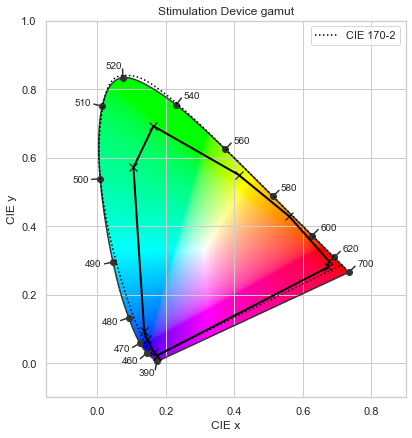

In [3]:
_ = device.plot_gamut()

Requested LMS: [ 0.90570028  0.71772948  0.204594  ]
Solution LMS: [ 0.9057002   0.71772946  0.20459405]


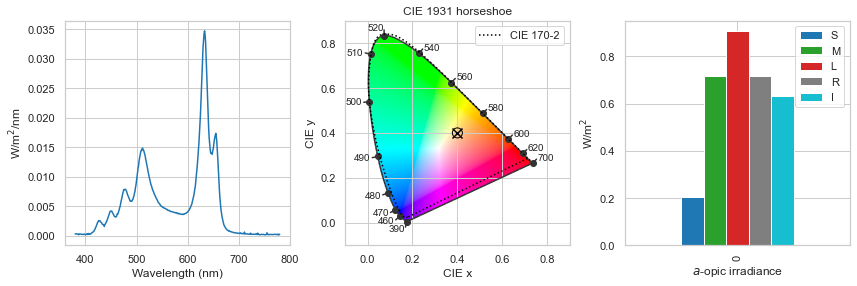

In [4]:
import numpy as np

from scipy.optimize import basinhopping, Bounds, minimize
from colour.plotting import plot_chromaticity_diagram_CIE1931

from silentsub.colorfunc import xyY_to_LMS, LMS_to_xyY, xyY_to_XYZ


# The background finding problem
class FindBackground:
    def __init__(self, xyY):
        self.lms = xyY_to_LMS(xyY)
        
    def objective_function(self, x0):
        aopic = device.predict_multiprimary_aopic(x0)
        return sum(pow(self.lms - aopic[['L','M','S']].to_numpy()[0], 2))

# Requested background 
requested_xyY = [.4, .4, 600.] 
fb = FindBackground(requested_xyY)

# Do optimisation
x0 = np.random.rand(1, device.nprimaries)[0]
bounds = Bounds(np.ones((device.nprimaries))*0,
                np.ones((device.nprimaries))*1)
result = minimize(fun=fb.objective_function, x0=x0, bounds=bounds, options={'maxiter': 1000})

# Get the LMS of solution and print
solution_lms = device.predict_multiprimary_aopic(result.x)[['L','M','S']].values[0]
print(f'Requested LMS: {fb.lms}')
print(f'Solution LMS: {solution_lms}')

# Plot
fig, axs = stim_plot()

# Plot the spectrum
device.predict_multiprimary_spd(result.x).T.plot(ax=axs[0], legend=False)

# Plot solution on horseshoe
solution_xyY = LMS_to_xyY(solution_lms)
axs[1].scatter(x=requested_xyY[0], y=requested_xyY[1], s=100, marker='o', facecolors='none', edgecolors='k', label='Requested')
axs[1].scatter(x=solution_xyY[0], y=solution_xyY[1], s=100, c='k', marker='x', label='Solution')

# Plot aopic irradiances
device_ao = device.predict_multiprimary_aopic(result.x)
device_ao.plot(kind='bar', color=device.aopic_colors, ax=axs[2]);


In [5]:
ao = device_ao.melt(var_name='opic', value_name='W/m2').reset_index()
ao

,index,opic,W/m2
0,0,S,0.204594
1,1,M,0.717729
2,2,L,0.905700
3,3,R,0.733764
4,4,I,0.638640


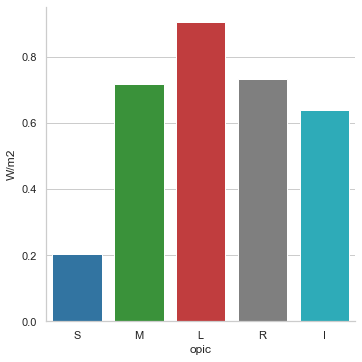

In [6]:
sns.catplot(data=ao, y='W/m2', x='opic', kind='bar', palette=device.aopic_colors)